# Imports

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import json
import pandas as pd

In [2]:
import math

def distCalc(pt1, pt2):
    dis = math.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2)
    return dis

def calc_dist_from_4m(fencer):
    # Negative if to the left of engarde, positive otherwise
    if (fencer[0] < pisteLines['leftEngardeLine'][0]):
        # Left side
        distFromLeftEGLine = leftEngardeToLeftWarning * (fencer[0] - pisteLines['leftEngardeLine'][0])
        return distFromLeftEGLine - 200
    elif (fencer[0] < pisteLines['middleLines'][0]):
        distFromMidLine = leftEnGardeToMid * (fencer[0] - pisteLines['middleLines'][0])
        return distFromMidLine
    elif (fencer[0] < pisteLines['rightEngardeLine'][0]):
        distFromMidLine = rightEnGardeToMid * (fencer[0] - pisteLines['middleLines'][0])
        return distFromMidLine
    else:
        distFromRightEGLine = rightEngardeToRightWarning * (fencer[0] - pisteLines['rightEngardeLine'][0])
        return 200 + distFromRightEGLine

# Get momentum graph time and alphapose data

In [3]:
# Navigate to alphapose data
os.chdir('./ellevskor/output')
left_df = pd.read_csv('./left_momentum_results.csv', header=None)
left_fencer = left_df.to_records(index=False).tolist()

right_df = pd.read_csv('./right_momentum_results.csv', header=None)
right_fencer = right_df.to_records(index=False).tolist()
pisteLines_df = pd.read_csv('./pisteLines.csv')
pisteLines = {}
pisteLines['middleLines'] = (pisteLines_df['middleLines'][0], pisteLines_df['middleLines'][1])
pisteLines['leftEngardeLine'] = (pisteLines_df['leftEngardeLine'][0], pisteLines_df['leftEngardeLine'][1])
pisteLines['rightEngardeLine'] = (pisteLines_df['rightEngardeLine'][0], pisteLines_df['rightEngardeLine'][1])
pisteLines['leftWarningLine'] = (pisteLines_df['leftWarningLine'][0], pisteLines_df['leftWarningLine'][1])
pisteLines['rightWarningLine'] = (pisteLines_df['rightWarningLine'][0], pisteLines_df['rightWarningLine'][1])
leftEnGardeToMid = 200 / distCalc(pisteLines['middleLines'], pisteLines['leftEngardeLine'])
rightEnGardeToMid = 200 / distCalc(pisteLines['middleLines'], pisteLines['rightEngardeLine'])
leftEngardeToLeftWarning = 300 / distCalc(pisteLines['leftEngardeLine'], pisteLines['leftWarningLine'])
rightEngardeToRightWarning = 300 / distCalc(pisteLines['rightEngardeLine'], pisteLines['rightWarningLine'])

left_dist = []
for coord in left_fencer:
    left_dist.append(calc_dist_from_4m(coord))
    
right_dist = []
for coord in right_fencer:
    right_dist.append(calc_dist_from_4m(coord))
    
dist_bw_fencers = []
for i in range(len(left_dist)):
    dist_bw_fencers.append(((right_dist[i] + 700) - (left_dist[i] + 700)))

vel_left = []
for i in range(len(left_dist) - 1):
    vel_left.append((left_dist[i + 1] - left_dist[i]))
    
vel_right = []
for i in range(len(right_dist) - 1):
    vel_right.append((right_dist[i + 1] - right_dist[i]))
    
os.chdir('../..')

In [4]:
results = pd.read_csv('ellevskor/momentum_results.csv', header=None)

In [5]:
## For epee if both score points, may also help to solve accidental scoring
last_time = results[0][0]
last_momentum = results[1][0]

results_time = [last_time]
results_momentum = [last_momentum]

for i in range(1, len(results[0])):
    time = results[0][i]
    momentum = results[1][i]
    
    if (time - last_time) < 5.0:
        # Score should be for both sides
        results_momentum[-1] = momentum
    elif (min(dist_bw_fencers[int(last_time*30) : int(time*30)]) > 400):
        results_momentum[-1] = momentum
    else:
        results_time.append(time)
        results_momentum.append(momentum)
    last_time = time
    last_momentum = momentum
    
results_time_by_frame = [i * 30 for i in results_time]

In [6]:
start = int(results_time_by_frame[0])
end = int(results_time_by_frame[1])
frames = [i for i in range(start, end)]

Text(0.5, 1.0, 'Right Velocity')

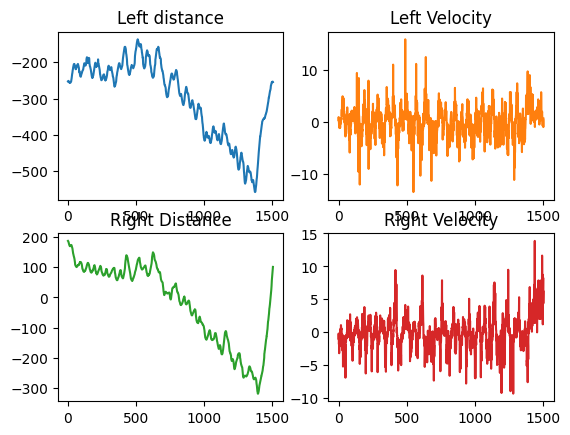

In [7]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(frames, left_dist[:end])
axs[0, 0].set_title('Left distance')
axs[0, 1].plot(frames, vel_left[:end], 'tab:orange')
axs[0, 1].set_title('Left Velocity')
axs[1, 0].plot(frames, right_dist[:end], 'tab:green')
axs[1, 0].set_title('Right Distance')
axs[1, 1].plot(frames, vel_right[:end], 'tab:red')
axs[1, 1].set_title('Right Velocity')

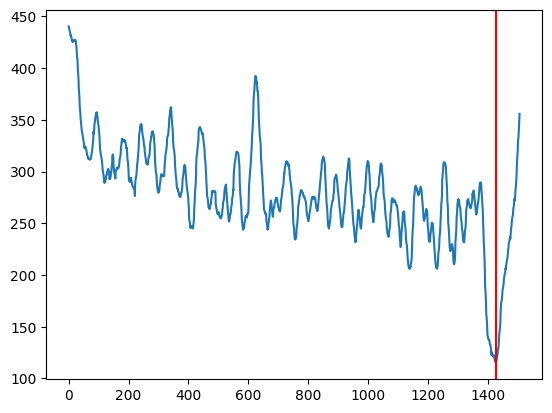

In [8]:
plt.figure()
plt.plot(frames, dist_bw_fencers[start:end])
plt.axvline(x = dist_bw_fencers.index(min(dist_bw_fencers[start:end])), color = 'r')

In [9]:
start = int(results_time_by_frame[1])
end = int(results_time_by_frame[2])
frames = [i for i in range(start, end)]

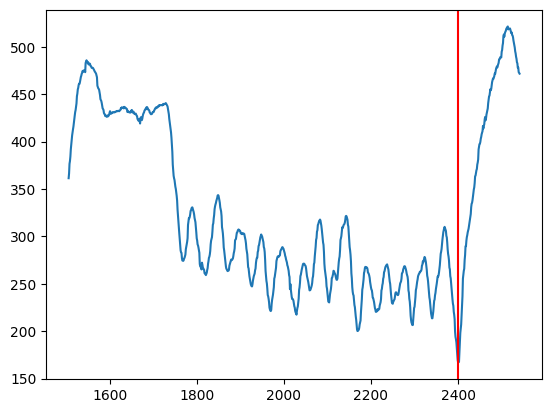

In [10]:
plt.figure()
plt.plot(frames, dist_bw_fencers[start:end])
plt.axvline(x = dist_bw_fencers.index(min(dist_bw_fencers[start:end])), color = 'r')

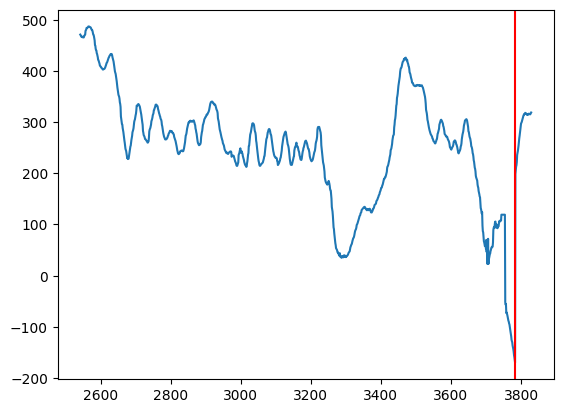

In [11]:
start = int(results_time_by_frame[2])
end = int(results_time_by_frame[3])
frames = [i for i in range(start, end)]
plt.figure()
plt.plot(frames, dist_bw_fencers[start:end])
plt.axvline(x = dist_bw_fencers.index(min(dist_bw_fencers[start:end])), color = 'r')

## Create a loop to run through all the timings and find point of action

In [12]:
## Left fencer score, -200 -> L, -200 - 200 -> M, > 200 -> R
def score_location(dist_chart, time):
    score_dist = dist_chart[time]
    if (score_dist < -200):
        return "L"
    elif (-200 <= score_dist and score_dist <= 200):
        return "M"
    else:
        return "R"
    
def did_left_score(prev_momentum, curr_momentum):
    # Momentum calculated by Left - Right
    return (prev_momentum < curr_momentum)

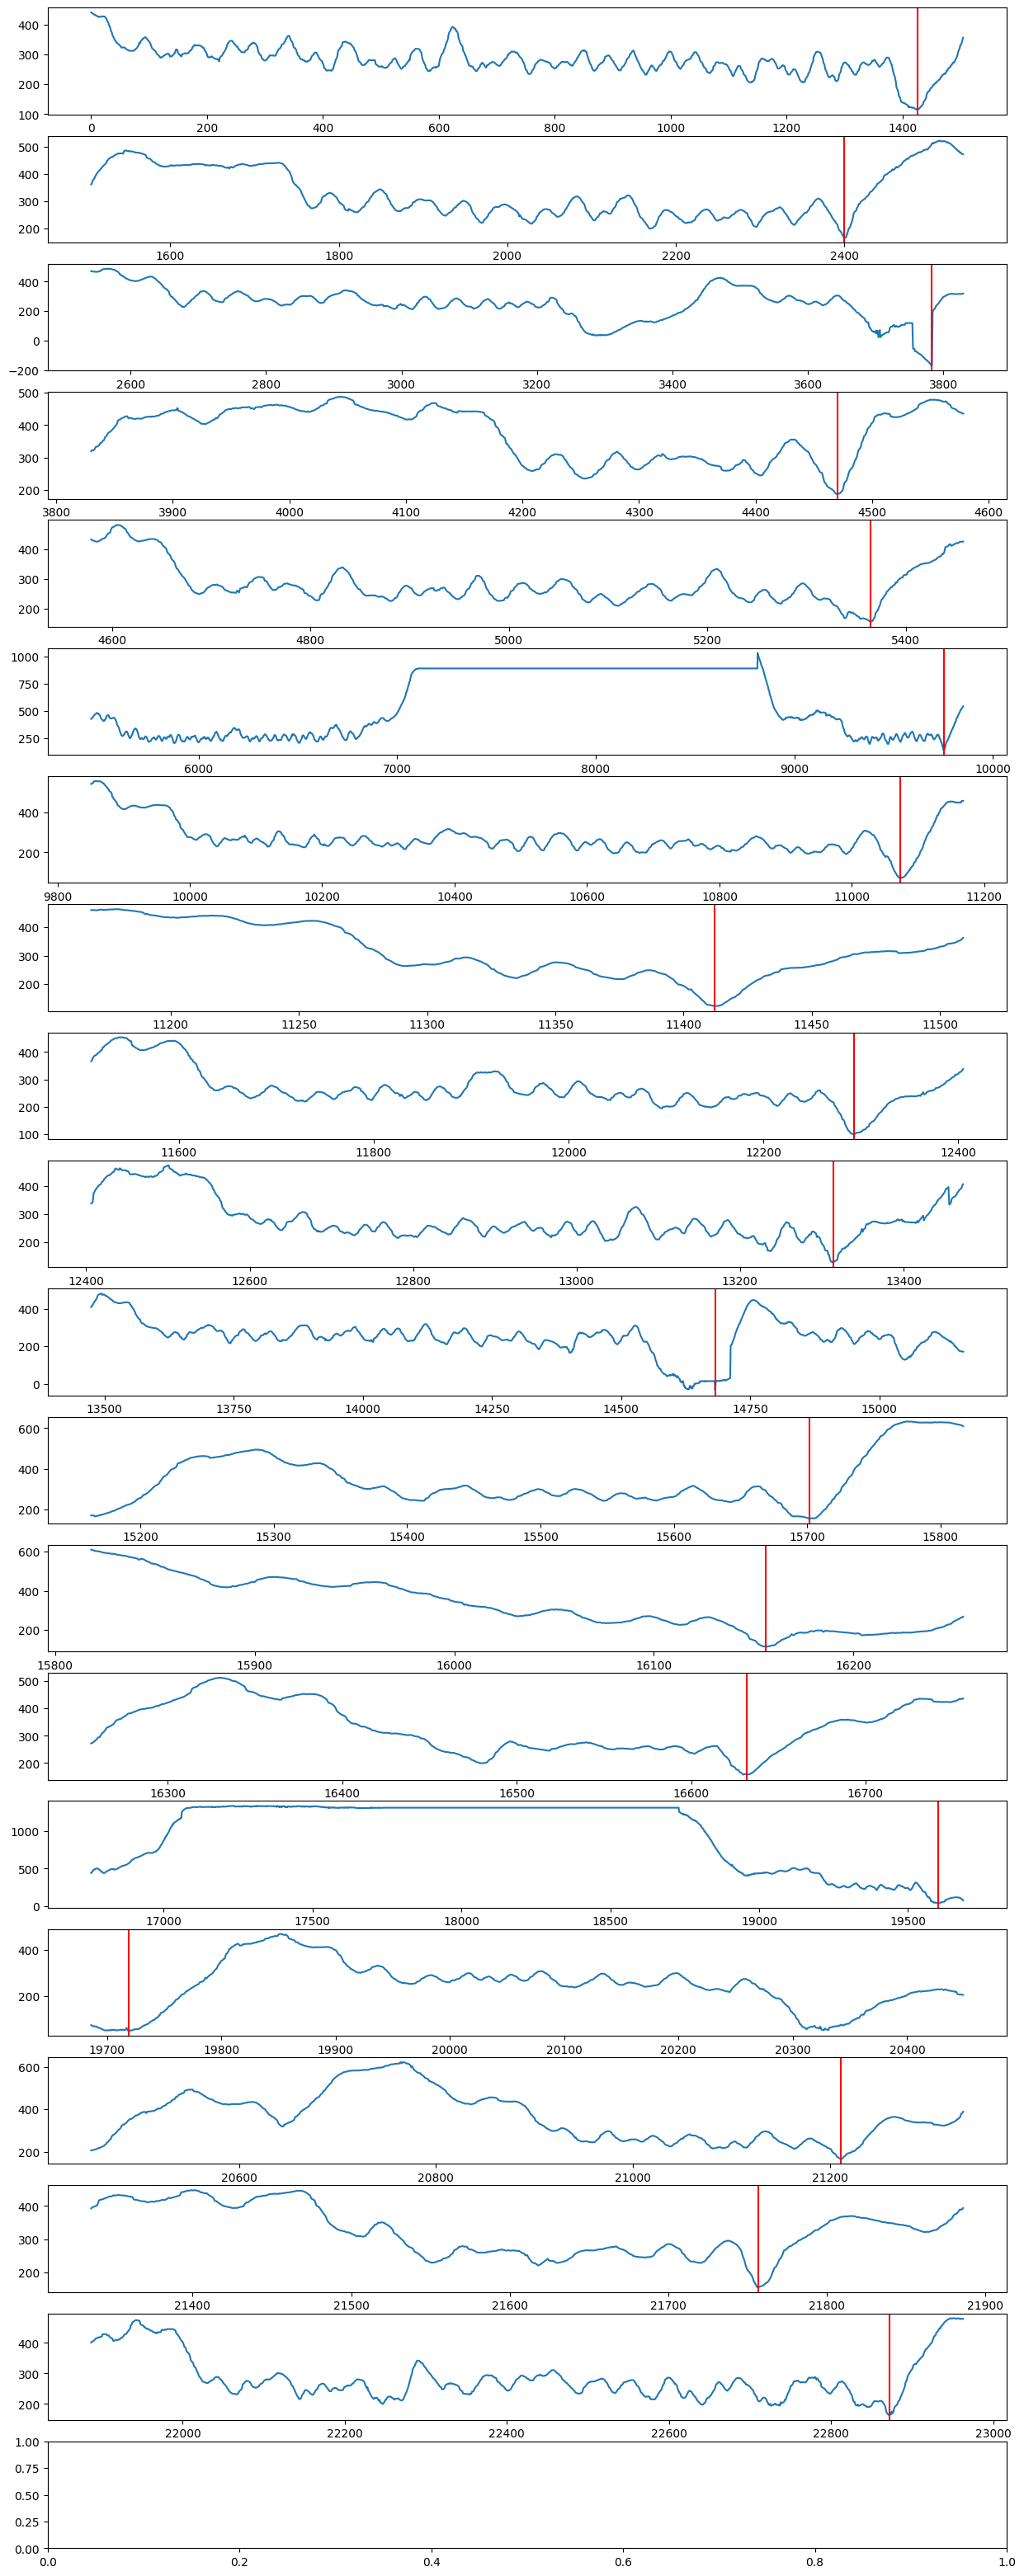

In [14]:
minpts = []
fig, axs = plt.subplots(len(results_time_by_frame), figsize=(15,40), sharex=False)
for index in range(1, len(results_time_by_frame)):
    start = int(results_time_by_frame[index - 1])
    end = int(results_time_by_frame[index])
    
    hit_time = dist_bw_fencers.index(min(dist_bw_fencers[start:end]))
    frames = [i for i in range(start, end)]
    axs[index - 1].plot(frames, dist_bw_fencers[start:end])
    axs[index - 1].axvline(x = hit_time, color = 'r')
    
    if (did_left_score(results_momentum[index - 1], results_momentum[index])):
        score_loc = score_location(left_dist, hit_time)
    else:
        score_loc = score_location(right_dist, hit_time)
    minpts.append((hit_time, score_loc))

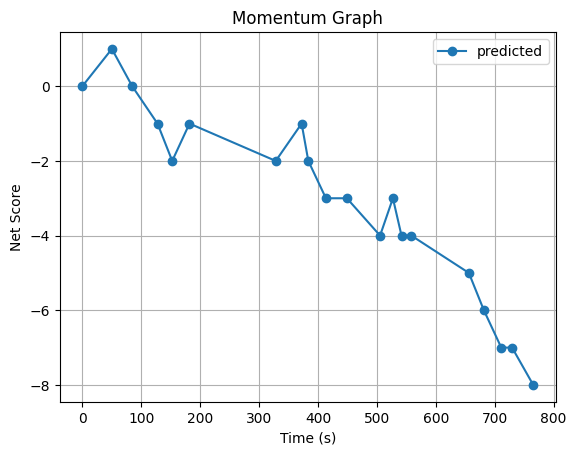

In [15]:
plt.title("Momentum Graph")
plt.xlabel("Time (s)")
plt.ylabel("Net Score")
plt.grid()
plt.plot(results_time, results_momentum, marker='o', label='predicted')
plt.legend()

In [18]:
hit_timings = [i[0]/30 for i in minpts]
hit_timings

[47.53333333333333,
 80.0,
 126.1,
 149.0,
 178.83333333333334,
 325.06666666666666,
 369.1,
 380.4,
 409.76666666666665,
 443.8,
 489.4,
 523.4,
 538.5333333333333,
 554.4,
 653.3333333333334,
 657.3,
 707.0333333333333,
 725.2333333333333,
 762.4]

In [16]:
minpts

[(1426, 'L'),
 (2400, 'L'),
 (3783, 'M'),
 (4470, 'M'),
 (5365, 'M'),
 (9752, 'L'),
 (11073, 'M'),
 (11412, 'M'),
 (12293, 'M'),
 (13314, 'R'),
 (14682, 'R'),
 (15702, 'R'),
 (16156, 'M'),
 (16632, 'R'),
 (19600, 'R'),
 (19719, 'M'),
 (21211, 'M'),
 (21757, 'R'),
 (22872, 'R')]